In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from statsmodels import api as sm
from re import match
from datetime import datetime as dt

sns.set()
sns.set(rc={'figure.figsize':(30,8)})
SNS_CMAP = sns.light_palette("seagreen", as_cmap=True)
SNS_COLOR = sns.color_palette('muted')

# Preparation: Evaluator

In [282]:
class Evaluator():
  from datetime import datetime as dt
  from scipy.stats import t

  ff3_reader = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='1900-01-01',end=str(dt.today()))
  ff3 = ff3_reader.read()[0]/100
  ff3_reader.close()

  mom_reader = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='1900-01-01',end=str(dt.today()))
  mom = mom_reader.read()[0]/100
  mom_reader.close()

  fourFactor = pd.concat([ff3,mom],axis=1)
  def __init__(self,returns):
    self.set_returns(returns)
    self.set_fourFactor()
  def set_fourFactor(self):
    self.fourFactor['Strategy-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    summary = pd.DataFrame()
    summary.loc['Cum Return',['Value','Sample size']] = self.get_cumRet()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size','P-value']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Beta',['Value','Sample size','P-value']] = self.get_beta()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Skew (M)',['Value','Sample size']] = self.get_monthlySkew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_beta(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    beta = result.params[1]
    p = result.pvalues[1]
    return beta,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CAPMSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_CarhartSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_factorCorr(self):
    return self.fourFactor.corr()
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.fourFactor['Strategy-RF'].mean()/self.fourFactor['Strategy-RF'].std()*np.sqrt(252)
    sampleSize = self.returns.size

    t_stat = sharpeRatio * np.sqrt(sampleSize)
    # p-value for 2-sided test
    p_2sided = 2*(1 - Evaluator.t.cdf(abs(t_stat), sampleSize))

    return sharpeRatio,sampleSize,p_2sided
  def get_monthlyReturns(self):
    monthlyReturns = (1+self.returns).resample('M').prod()-1
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())*np.sqrt(252)
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod/cumprod.expanding().max() - 1
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_8404/3269245964.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = ff3_reader.read()[0]/100
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_8404/3269245964.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = mom_reader.read()[0]/100


# Preparation: data

In [223]:
symbols = ['EURUSD=X','USDJPY=X','GBPUSD=X','USDCHF=X','AUDUSD=X','USDCAD=X','NZDUSD=X']

data = dict()
for symbol in symbols:
    data[symbol] = yf.download(symbol,interval='1d')

/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.Timed

# Add TA indicators

In [224]:
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.volatility import BollingerBands
from ta.volume import AccDistIndexIndicator
from ta.volatility import AverageTrueRange

In [225]:
def add_ta_signals(df):
    df = df.copy()

    o,h,l,c,v = df['Open'],df['High'],df['Low'],df['Close'],df['Volume']
    
    df['Ret'] = np.log(c).diff().shift(-1)

    df['MACDD'] = MACD(c).macd_diff()
    df['MACDS'] = MACD(c).macd_signal()

    df['RSI'] = RSIIndicator(c).rsi()

    df['SO'] = StochasticOscillator(h,l,c).stoch()
    df['SOS'] = StochasticOscillator(h,l,c).stoch_signal()

    df['BBH'] = BollingerBands(c).bollinger_hband_indicator() - c
    df['BBL'] = BollingerBands(c).bollinger_lband_indicator() - c

    df['ADI'] = AccDistIndexIndicator(h,l,c,v).acc_dist_index()

    df['HLR'] = c / (h.rolling(252).max() - l.rolling(252).min()) - 1 / 2

    df['ATR'] = AverageTrueRange(h,l,c).average_true_range()

    return df.drop(columns=['Open','High','Low','Close','Adj Close','Volume'])

In [273]:
ta_data = dict()
for symbol in symbols:
    ta_data[symbol] = add_ta_signals(data[symbol]).dropna()

In [274]:
train_data = dict()
test_data = dict()
frac = round(len(ta_data[symbols[0]]) * 0.1)
for symbol in symbols:
    train_data[symbol] = ta_data[symbol].iloc[:-frac]
    test_data[symbol] = ta_data[symbol].iloc[-frac:]

# KNN Model

In [275]:
concat_train_data = pd.concat(train_data.values())

In [276]:
from sklearn.neighbors import KNeighborsClassifier

knns = [KNeighborsClassifier(n_neighbors=10) for _ in range(100)]
for i,knn in enumerate(knns):
        bootstrap_train_data = concat_train_data.sample(frac=0.01,replace=True)
        knn.fit(X=bootstrap_train_data.iloc[:,1:],
                y=np.sign(bootstrap_train_data.iloc[:,0]))

In [277]:
for symbol in symbols:
    df = test_data[symbol]
    pos = pd.DataFrame()
    for i,knn in enumerate(knns):
        pos[f'{i}'] = knn.predict(df.iloc[:,1:])
    df['Pos'] = np.around(pos.mean(axis=1).to_numpy()*2)/2
    df['Pnl'] = df['Pos'] * df['Ret']

/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_8404/2205493965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pos'] = np.around(pos.mean(axis=1).to_numpy()*2)/2
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_8404/2205493965.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pnl'] = df['Pos'] * df['Ret']
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_8404/2205493965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

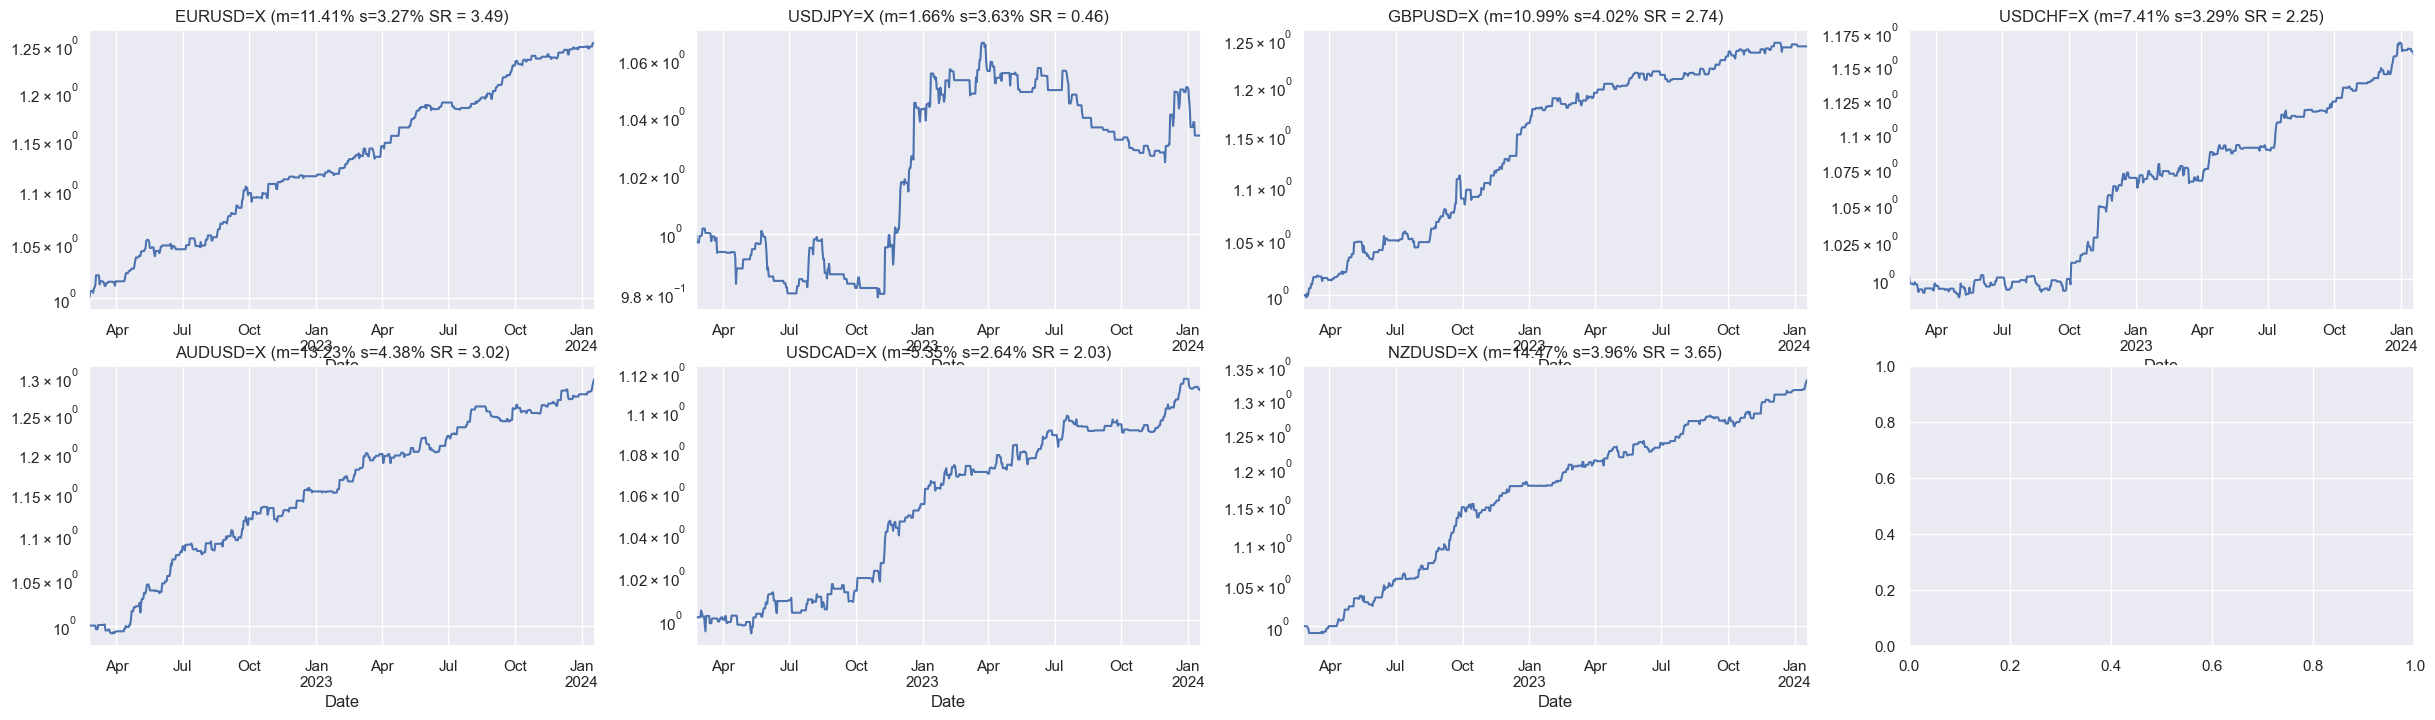

In [278]:
fig,axes = plt.subplots(2,4)
for i,symbol in enumerate(symbols):
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s

    r,c = i//4,i%4
    ax = axes[r,c]
    np.exp(df['Pnl'].resample("d").sum().cumsum()).plot(title=f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})',ax=ax)
    ax.set_yscale('log')

In [279]:
test_return = pd.DataFrame()
for symbol in symbols:
    df = test_data[symbol]
    test_return[symbol] = df['Pnl']

In [280]:
test_return_weight = 1/test_return.rolling(30).std()
test_return_weight = test_return_weight.div(test_return_weight.sum(axis=1),axis=0)

Text(0.5, 1.0, 'Portfolio of 7 major pairs (m=9.22% s=1.66% SR = 5.54)')

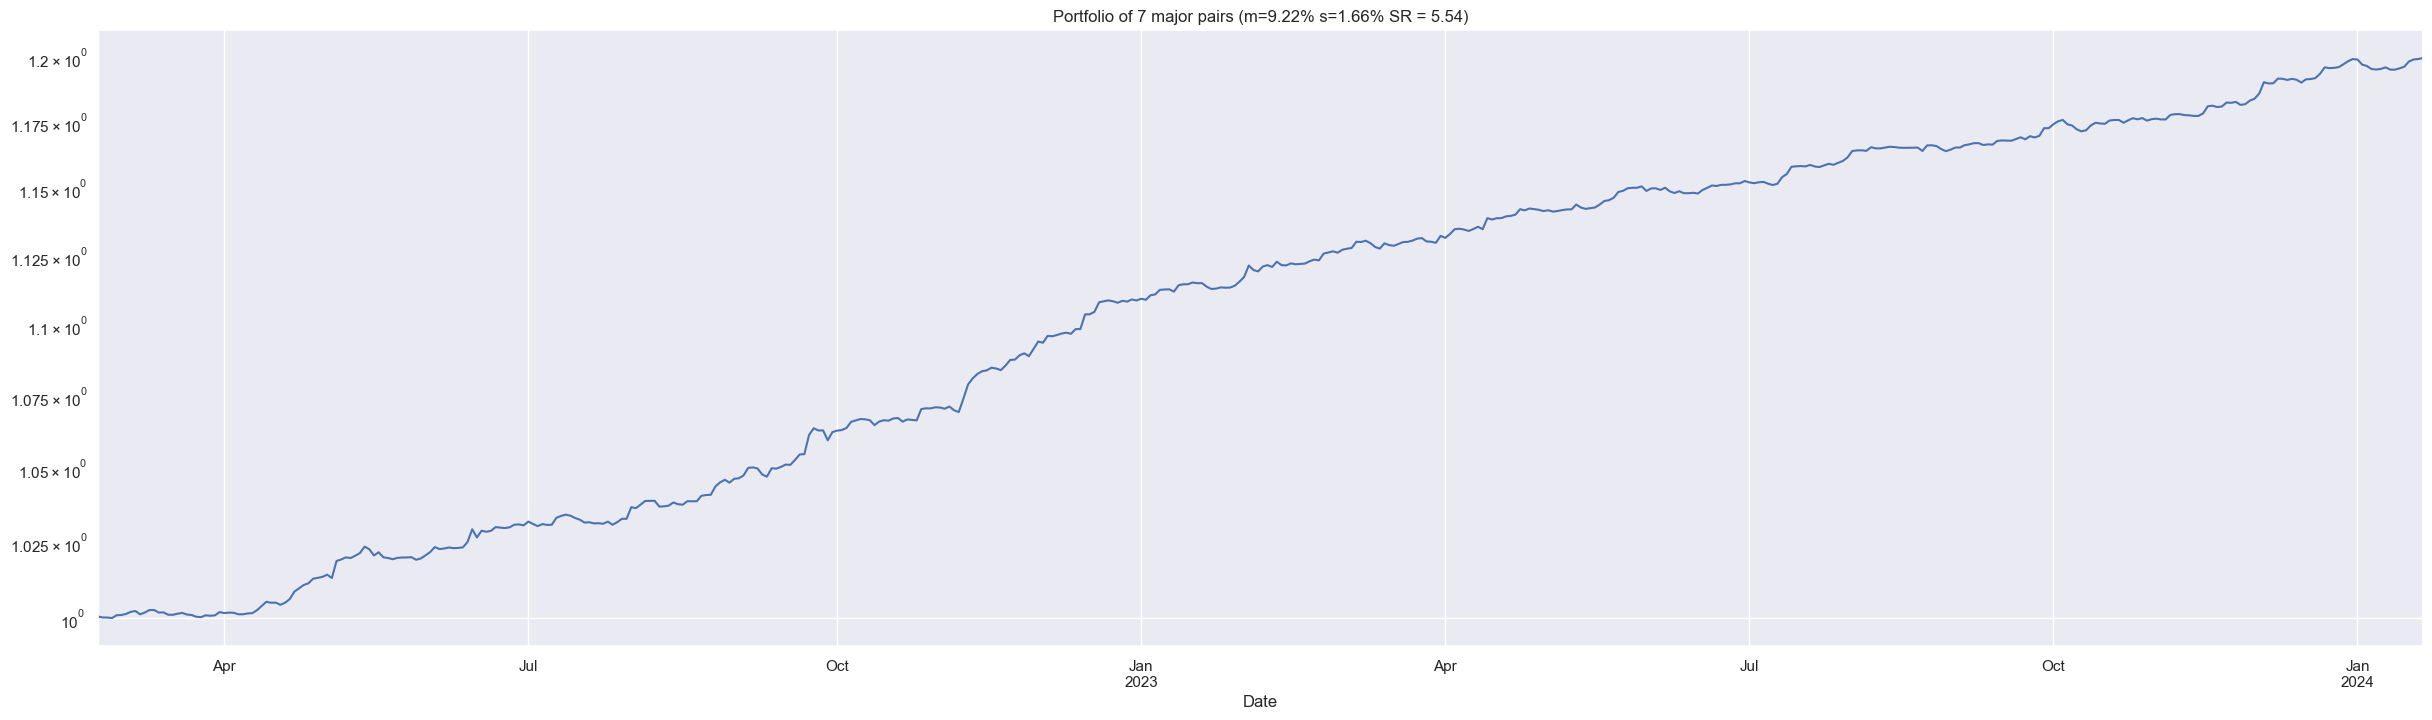

In [281]:
#port_return = (test_return * test_return_weight.shift(1)).sum(axis=1)
port_return = test_return.mean(axis=1)

m = port_return.mean()*252
s = port_return.std()*252**0.5
SR = m/s

ax = np.exp(port_return.cumsum()).plot()
ax.set_yscale('log')
ax.set_title(f'Portfolio of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

In [283]:
Evaluator(port_return).get_summary()

/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_8404/3269245964.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumprod = self.get_cumprod()[-1]
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_8404/3269245964.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = result.params[0]*252
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_8404/3269245964.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

,Value,Sample size,P-value
Cum Return,0.1994,1.0000,NaN
Mean,0.0922,498.0000,NaN
Vol,0.0166,498.0000,NaN
SR,3.7117,498.0000,0.0000
CAPM Alpha,0.0633,446.0000,0.0000
Carhart Alpha,0.0637,446.0000,0.0000
Beta,-0.0138,446.0000,0.0004
Skew,1.3913,498.0000,NaN
Skew (M),0.5789,24.0000,NaN
Kurt,4.9529,498.0000,NaN
